In [1]:
#!/usr/bin/python
# -*- coding: GBK -*-
%matplotlib inline
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

In [2]:
# Convenience functions for working with colour ramps and bars
def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

In [3]:
shp = fiona.open('CHN_adm_shp/CHN_adm2.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1]) # lower-left
ur = (bds[2], bds[3]) # upper-right
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
print(coords)
print('w = {}, h = {}'.format(w, h))

[73.55770111084013, 18.159305572509766, 134.77392578125034, 53.56085968017585]
w = 61.21622467041021, h = 35.40155410766609


In [4]:
m = Basemap(
    projection='tmerc',
    lon_0 = (coords[0] + coords[2])/2,
    lat_0 = (coords[1] + coords[3])/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra + 0.05 * w,
    llcrnrlat=coords[1] - extra - 0.1 * h,
    urcrnrlon=coords[2] + extra + 0.05 * w,
    urcrnrlat=coords[3] + extra - 0.1 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(2408,
 5,
 [73.55770111083996, 18.159305572509766, 0.0, 0.0],
 [134.77392578125, 53.5608596801759, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x123251668>)

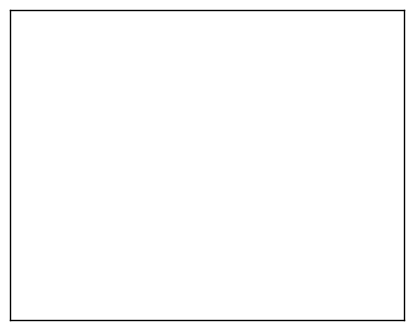

In [5]:
m.readshapefile(
    'CHN_adm_shp/CHN_adm3',
    name='china',
    color='none',
    zorder=2)

In [6]:
n = Basemap(
    projection='tmerc',
    lon_0 = (coords[0] + coords[2])/2,
    lat_0 = (coords[1] + coords[3])/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra + 0.05 * w,
    llcrnrlat=coords[1] - extra - 0.1 * h,
    urcrnrlon=coords[2] + extra + 0.05 * w,
    urcrnrlat=coords[3] + extra - 0.1 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

(22,
 5,
 [116.70999908447266, 20.697500228881836, 0.0, 0.0],
 [122.10847473144545, 26.385419845581104, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x116d06128>)

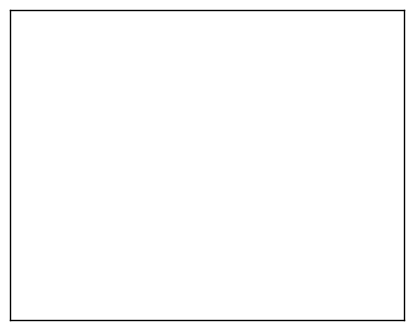

In [7]:
n.readshapefile(
    'TWN_adm_shp/TWN_adm2',
    name='taiwan',
    color='none',
    zorder=2)

In [8]:
# set up a map dataframe for China
df_map_cn = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.china],
    'NAME_3': [region['NAME_3'] for region in m.china_info]})
df_map_cn['poly_area_m2'] = df_map_cn['poly'].map(lambda x: x.area)
df_map_cn['poly_area_km2'] = df_map_cn['poly_area_m2'] / 1000000
df_map_cn['poly_area_100km2'] = df_map_cn['poly_area_km2'] / 100
df_map_cn['region_area_m2'] = df_map_cn.NAME_3.apply(df_map_cn.groupby('NAME_3').sum().poly_area_m2.get_value)
df_map_cn['region_area_km2'] = df_map_cn['region_area_m2'] / 1000000
df_map_cn['region_area_100km2'] = df_map_cn['region_area_km2'] / 100

In [9]:
# set up a map dataframe for Taiwan
df_map_tw = pd.DataFrame({
    'poly': [Polygon(xy) for xy in n.taiwan],
    'NAME_3': [region['NAME_2'] for region in n.taiwan_info]})
df_map_tw['poly_area_m2'] = df_map_tw['poly'].map(lambda x: x.area)
df_map_tw['poly_area_km2'] = df_map_tw['poly_area_m2'] / 1000000
df_map_tw['poly_area_100km2'] = df_map_tw['poly_area_km2'] / 100
df_map_tw['region_area_m2'] = df_map_tw.NAME_3.apply(df_map_tw.groupby('NAME_3').sum().poly_area_m2.get_value)
df_map_tw['region_area_km2'] = df_map_tw['region_area_m2'] / 1000000
df_map_tw['region_area_100km2'] = df_map_tw['region_area_km2'] / 100

In [10]:
rows_cn = df_map_cn.poly.count()
rows_tw = df_map_tw.poly.count()
df_map_tw.set_index([list(range(rows_cn+1, rows_cn+rows_tw+1))], inplace=True)

In [11]:
df_map = df_map_cn.append(df_map_tw)

Choropleth map

In [12]:
df_price = pd.read_csv('price.csv')

In [13]:
df_map = pd.merge(df_map, df_price, how='left', on='NAME_3')

In [14]:
df_map['density_m2'] = df_map['price(million)'] / df_map['region_area_m2'] /100
df_map['density_km2'] = df_map['price(million)'] / df_map['region_area_km2'] /100
df_map['density_100km2'] = df_map['price(million)'] / df_map['region_area_100km2'] /100
# it's easier to work with NaN values when classifying
# df_map.replace(to_replace={'density_m2': {0: np.nan}, 'density_km2': {0: np.nan},
#                'density_100km2': {0: np.nan}}, inplace=True)

In [15]:
df_map_temp = df_map

In [16]:
df_map = df_map_temp

In [17]:
# # Calculate Jenks natural breaks for density
# breaks = nb(
#     df_map[df_map['density_100km2'].notnull()]['density_100km2'].values,
#     initial=300,
#     k=5)
# # the notnull method lets us match indices when joining
# jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_100km2'].notnull()].index)
# df_map = df_map.join(jb)
# df_map.jenks_bins.fillna(-1, inplace=True)
# jenks_labels = ["<= {:d} establishments per 100 km$^2$".format(int(b)) for b in breaks.bins]
# # jenks_labels.insert(0, 'No region (%s regions)' % len(df_map[df_map['density_km'].isnull()]))

In [18]:
print(min(list(df_map['density_100km2'].values)))
print(max(list(df_map['density_100km2'].values)))

0.00245918549149
231185.585843


In [31]:
# User-defined jenks bins
def self_categorize(entry, breaks):
    for i in range(0, len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return 0

breaks = [0., 8., 128., 2048., 16384., 262144.] + [1e20]
df_map['jenks_bins'] = df_map['density_100km2'].apply(self_categorize, args=(breaks,))
jenks_labels = ["<= {:d} million RMB per 100 km$^2$".format(int(perc)) for perc in breaks[1:-1]]

print(jenks_labels)

['<= 8 million RMB per 100 km$^2$', '<= 128 million RMB per 100 km$^2$', '<= 2048 million RMB per 100 km$^2$', '<= 16384 million RMB per 100 km$^2$', '<= 262144 million RMB per 100 km$^2$']


In [32]:
print(min(list(df_map['jenks_bins'].values)))
print(max(list(df_map['jenks_bins'].values)))

0
4


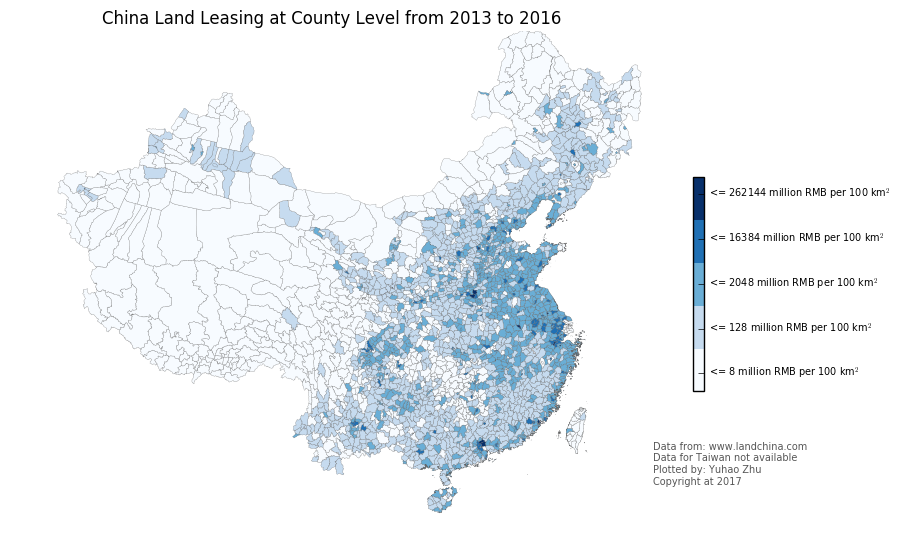

In [33]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
# http://matplotlib.org/examples/color/colormaps_reference.html
cmap = plt.get_cmap('Blues')

# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=0.75, zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.3, labels=jenks_labels)
cb.ax.tick_params(labelsize=7)

# # Show highest densities, in descending order
# highest = '\n'.join(
#     value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
# highest = 'Most Dense Region:\n' + highest

# # Subtraction is necessary for precise y coordinate alignment
# details = cb.ax.text(
#     -1., 0 - 0.007,
#     highest,
#     ha='right', va='bottom',
#     size=5,
#     color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    1, 0.1,
    'Data from: www.landchina.com\nData for Taiwan not available\nPlotted by: Yuhao Zhu\nCopyright at 2017',
    ha='left', va='bottom',
    size=7,
    color='#555555',
    transform=ax.transAxes)

m.scatter(
    [geom.x for geom in []],
    [geom.y for geom in []],
    15, marker='o', lw=.5,
    facecolor='grey', edgecolor='w',
    alpha=1.0, antialiased=True,
    label='Million RMB per square kilometers of land sold 2013 to 2016', zorder=3, ax=ax,)

# Draw a map scale
# m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
#     (coords[0] + coords[2])/2, (coords[1] + coords[3])/2, length = 2000.,
#     fontsize=6, barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
#     zorder=0, ax=ax,)

ax.set_title('China Land Leasing at County Level from 2013 to 2016')

# this will set the image width
plt.tight_layout()
fig.set_size_inches(12, 8)
plt.savefig('landchina_2013_2016.png', dpi=720, alpha=True)
plt.show()